In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

import NaiveDE
import SpatialDE

from matplotlib import pyplot as plt

import time

import random
from random import sample

from SC2Spa import Vis

/mnt/win1
/mnt/win1/SC2Spa_Notebook/SVA_BM


In [8]:
def pp(adata):
    adata.var_names_make_unique()
    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

def SpaDE(adata, Sparse = True, x_name = 'xcoord', y_name = 'ycoord', output='SpatialDE_HC1.csv'):
    
    if(Sparse):
        norm_expr = NaiveDE.stabilize(adata.raw.X.toarray().T).T
    else:
        norm_expr = NaiveDE.stabilize(adata.raw.X.T).T
        
    norm_expr = pd.DataFrame(norm_expr, columns = adata.var_names.tolist(),
                             index = adata.obs_names.tolist())
    
    sta = time.time()

    X = adata.obs[[x_name, y_name]]
    
    if(adata.shape[0]>30000):
        random.seed(2022)
        sample_index = sample(range(adata.shape[0]), 30000)
        results = SpatialDE.run(X.iloc[sample_index], norm_expr.iloc[sample_index])
    else:
        results = SpatialDE.run(X, norm_expr)

    end = time.time()
    print((end - sta) / 60.0, 'min')
    
    results.to_csv(output)
    
    return results

In [3]:
adata_HC1 = ad.read_h5ad('../Dataset/AdataMH1.h5ad')
adata_HC2 = ad.read_h5ad('../Dataset/AdataMH2.h5ad')
adata_Em1 = ad.read_h5ad('../Dataset/AdataEmbryo1.h5ad')

ST = pd.read_csv('../MOB_Visium/MOBRep12_Processed.csv')
loc = pd.read_csv('../MOB_Visium/MOBRep12_loc.csv')[['x', 'y']]

adata_MOB = ad.AnnData(X=ST.values, obs = loc, var = pd.DataFrame(ST.columns).set_index(0))
adata_MOB.var.index.name = None

pp(adata_HC1)
pp(adata_HC2)
pp(adata_Em1)
pp(adata_MOB)

#HC1
Anno = pd.read_csv('../MouseHippocampus_SSV2/ssHippo_RCTD.csv', index_col = 0)
Anno['MCT'] = 't'

index1 = Anno.index[(Anno['celltype_1'] == Anno['celltype_2'])]
Anno['MCT'][index1] = Anno['celltype_1'][index1]
index2 = Anno.index[(Anno['celltype_1'] != Anno['celltype_2'])]
Anno['MCT'][index2] = (Anno['celltype_1'][index2] + '_' + Anno['celltype_2'][index2]).apply(lambda x: '_'.join(sorted(set(x.split('_')))))

adata_HC1.obs = adata_HC1.obs.merge(Anno, left_index = True, right_index = True, how = 'left')
adata_HC1_selected = adata_HC1[adata_HC1.obs['spot_class'].apply(lambda x: x in ['doublet_certain', 'singlet'])]

#Em1
Anno = pd.read_csv('../MouseEmbryo_SSV2/slideSeq_Puck190926_03_RCTD.csv', index_col = 0)
Anno['MCT'] = 't'

index1 = Anno.index[(Anno['celltype_1'] == Anno['celltype_2'])]
Anno['MCT'][index1] = Anno['celltype_1'][index1]
index2 = Anno.index[(Anno['celltype_1'] != Anno['celltype_2'])]
Anno['MCT'][index2] = (Anno['celltype_1'][index2] + '_' + Anno['celltype_2'][index2]).apply(lambda x: '_'.join(sorted(set(x.split('_')))))

adata_Em1.obs = adata_Em1.obs.merge(Anno, left_index = True, right_index = True, how = 'left')
adata_Em1_selected = adata_Em1[adata_Em1.obs['spot_class'].apply(lambda x: x in ['doublet_certain', 'singlet'])]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/linbuliao/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
results_HC1 = SpaDE(adata = adata_HC1, output='SpaDE/SpaDESpatialDE_HC1.csv')

In [3]:
results_HC2 = SpaDE(adata = adata_HC2, output='SpaDE/SpatialDE_HC2.csv')

/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/19227 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

  0%|          | 0/19227 [00:00<?, ?it/s]

276.5408626119296 min


In [ ]:
results_Em1 = SpaDE(adata_Em1, output='SpaDE/SpatialDE_Em1.csv')

/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/20220 [00:00<?, ?it/s]

/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

In [9]:
results_MOB = SpaDE(adata_MOB, Sparse = False, x_name = 'x',
                    y_name = 'y', output='SpaDE/SpatialDE_MOB.csv')

/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/14151 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

  0%|          | 0/14151 [00:00<?, ?it/s]

11.43946571747462 min


# Cell type specific

## HC1

In [4]:
CTs = adata_HC1_selected.obs['MCT'].value_counts()
is_doub = CTs.index.str.contains('_')

SCTs = CTs[~is_doub]
SCTs_selected = SCTs[SCTs > 500].index.tolist()
print(SCTs[SCTs > 500])

result_HC1_CTS = []
for CT in SCTs_selected:
    print(CT)
    t = SpaDE(adata = adata_HC1_selected[adata_HC1_selected.obs['MCT'] == CT],
                        output='SpaDE/SpatialDE_HC1_' + CT + '.csv')
    result_HC1_CTS.append(t)

O        2847
A        1700
Ec       1252
DPc      1055
CA1Pc     890
CA3Pc     795
I         786
Name: MCT, dtype: int64
O


/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

/home/linbuliao/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

19.36113237142563 min
A


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

12.157715618610382 min
Ec


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

15.78214529355367 min
DPc


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

14.914390397071838 min
CA1Pc


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

15.987781949838002 min
CA3Pc


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

12.656315032641093 min
I


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  0%|          | 0/20527 [00:00<?, ?it/s]

/home/linbuliao/anaconda3/lib/python3.9/site-packages/scipy/misc/common.py:144: RuntimeWarning: invalid value encountered in double_scalars
  val += weights[k]*func(x0+(k-ho)*dx,*args)


  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

  0%|          | 0/20527 [00:00<?, ?it/s]

18.501903239885966 min


## Em1

In [5]:
CTs = adata_Em1_selected.obs['MCT'].value_counts()
is_doub = CTs.index.str.contains('_')

SCTs = CTs[~is_doub]
SCTs_selected = SCTs[SCTs > 500].index.tolist()
print(SCTs[SCTs > 500])

result_Em1_CTS = []
for CT in SCTs_selected:
    print(CT)
    t = SpaDE(adata = adata_Em1_selected[adata_Em1_selected.obs['MCT'] == CT],
                        output='SpaDE/SpatialDE_Em1_' + CT + '.csv')
    result_Em1_CTS.append(t)

Sc     4655
My     1368
Ept     693
Name: MCT, dtype: int64
Sc


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

41.78558915456136 min
My


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

31.95531893968582 min
Ept


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

  0%|          | 0/20220 [00:00<?, ?it/s]

17.17993579308192 min


# Result Analysis

In [30]:


adata_HC1.var_names_make_unique()
adata_HC2.var_names_make_unique()
adata_Em1.var_names_make_unique()

Result_HC1 = pd.read_csv('SpatialDE_HC1.csv')
Result_HC2 = pd.read_csv('SpatialDE_HC2.csv')
Result_Em1 = pd.read_csv('SpatialDE_Em1.csv')

'''
for g in Result_HC1[Result_HC1['LLR'] == np.inf]['g'].tolist():
    print(g)
    print(pd.value_counts(adata_HC1[:,g].X.toarray().flatten()))
    
GM15401
0.0    35347
1.0        2
dtype: int64
GM15401
0.0    35347
1.0        2
dtype: int64
GM15915
0.0    35346
1.0        3
dtype: int64
GM15915
0.0    35346
1.0        3
dtype: int64
SPTA1
0.0    35346
1.0        3
dtype: int64
SPTA1
0.0    35346
1.0        3
dtype: int64
'''

Result_HC1 = Result_HC1[Result_HC1['LLR'] != np.inf]
Result_HC2 = Result_HC2[Result_HC2['LLR'] != np.inf]
Result_Em1 = Result_Em1[Result_Em1['LLR'] != np.inf]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<AxesSubplot:ylabel='Density'>

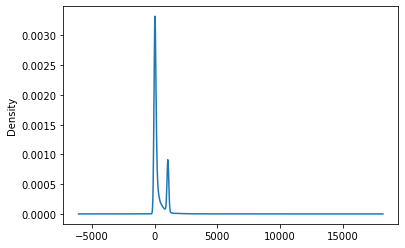

In [35]:
Result_HC1.LLR.plot.density()

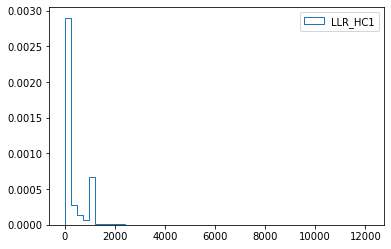

In [71]:
cum = False
bins = 50
loc = 'best'
n, bins, patches = plt.hist(Result_HC1['LLR'], bins, density = True,
                            histtype = 'step', cumulative = cum, label = 'LLR_HC1')
plt.legend(loc = loc)

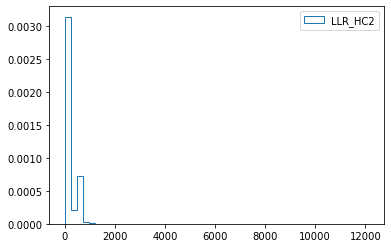

In [72]:
n, bins, patches = plt.hist(Result_HC2['LLR'], bins, density = True,
                            histtype = 'step', cumulative = cum, label = 'LLR_HC2')
plt.legend(loc = loc)

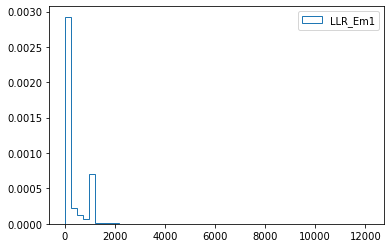

In [73]:
n, bins, patches = plt.hist(Result_Em1['LLR'], bins, density = True,
                            histtype = 'step', cumulative = cum, label = 'LLR_Em1')
plt.legend(loc = loc)

In [36]:
help(pd.Series.plot.density)

Help on function kde in module pandas.plotting._core:

kde(self, bw_method=None, ind=None, **kwargs)
    Generate Kernel Density Estimate plot using Gaussian kernels.
    
    In statistics, `kernel density estimation`_ (KDE) is a non-parametric
    way to estimate the probability density function (PDF) of a random
    variable. This function uses Gaussian kernels and includes automatic
    bandwidth determination.
    
    .. _kernel density estimation:
        https://en.wikipedia.org/wiki/Kernel_density_estimation
    
    Parameters
    ----------
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth. This can be
        'scott', 'silverman', a scalar constant or a callable.
        If None (default), 'scott' is used.
        See :class:`scipy.stats.gaussian_kde` for more information.
    ind : NumPy array or int, optional
        Evaluation points for the estimated PDF. If None (default),
        1000 equally spaced points a

In [31]:
Result_HC1.sort_values('LLR', ascending = False).head()

,Unnamed: 0,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
8377,8377,0.999955,4,GM13872,17.911729,0.000045,95248.867500,-1.302872,0.453396,SE,30000,1.234295e-10,0.043362,0.007323,-190456.499189,83108.900758,12139.966742,0.0,0.0
15745,15745,0.328099,4,TTR,146.014866,2.032490,-38370.450940,-0.628883,0.353131,SE,30000,7.313035e-07,0.000017,0.010845,76782.137691,-48541.820781,10171.369841,0.0,0.0
8380,8380,0.999955,4,GM26724,17.911729,0.000045,98710.903022,-1.302987,0.453425,SE,30000,1.335022e-10,0.046901,0.007100,-197380.570233,88646.069356,10064.833666,0.0,0.0
8420,8420,0.436851,4,1500015O10RIK,146.014866,1.279434,-775.045032,-1.261308,0.053007,SE,30000,1.839807e-06,0.000035,0.010671,1591.325875,-10385.127175,9610.082143,0.0,0.0
11641,11641,0.488568,4,HPCA,146.014866,1.038940,-41252.626978,-0.396123,0.820418,SE,30000,1.162417e-06,0.000022,0.009713,82546.489768,-50544.659932,9292.032954,0.0,0.0


In [32]:
Result_HC2.sort_values('LLR', ascending = False).head()

,Unnamed: 0,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
12883,12883,0.449610,4,HPCA,150.226295,1.214453,-20346.466071,-0.372457,0.525630,SE,16373,1.731864e-06,0.000033,0.006975,40731.745697,-24994.809647,4648.343576,0.0,0.0
10714,10714,0.999955,4,TERT,18.353642,0.000045,56221.435072,-0.988058,0.377218,SE,16373,1.450127e-09,0.509425,0.005110,-112404.056588,51850.419033,4371.016038,0.0,0.0
10651,10651,0.999955,4,GM19684,18.353642,0.000045,49790.294202,-0.987918,0.377243,SE,16373,1.484133e-09,0.521371,0.004781,-99541.774848,46176.553346,3613.740856,0.0,0.0
13838,13838,0.355102,4,NRGN,150.226295,1.801707,-19964.904248,-0.456825,0.344079,SE,16373,1.856653e-06,0.000040,0.007882,39968.622051,-23449.583053,3484.678805,0.0,0.0
10647,10647,0.999955,4,GM10640,18.353642,0.000045,41953.858084,-0.987476,0.377293,SE,16373,2.483108e-09,0.872307,0.005257,-83868.902612,38676.888626,3276.969458,0.0,0.0


In [33]:
Result_Em1.sort_values('LLR', ascending = False).head()

,Unnamed: 0,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
7022,7022,0.501833,4,CYP2J5,0.03323,0.992693,1.038741e+06,-1.351177,0.916186,SE,30000,5.127773e-12,9.604921e-11,0.020643,-2.077442e+06,201490.301622,837251.144055,0.0,0.0
7021,7021,0.501833,4,CYP2C29,0.03323,0.992693,1.038741e+06,-1.351177,0.916186,SE,30000,5.127773e-12,9.604921e-11,0.020883,-2.077442e+06,201490.301622,837251.144055,0.0,0.0
7027,7027,0.501833,4,DTHD1,0.03323,0.992693,1.038741e+06,-1.351177,0.916186,SE,30000,5.127773e-12,9.604921e-11,0.021561,-2.077442e+06,201490.301622,837251.144055,0.0,0.0
7017,7017,0.501833,4,ADGRF1,0.03323,0.992693,1.038741e+06,-1.351177,0.916186,SE,30000,5.127773e-12,9.604921e-11,0.020309,-2.077442e+06,201490.301622,837251.144055,0.0,0.0
7016,7016,0.501833,4,A130030D18RIK,0.03323,0.992693,1.038741e+06,-1.351177,0.916186,SE,30000,5.127773e-12,9.604921e-11,0.020970,-2.077442e+06,201490.301622,837251.144055,0.0,0.0


In [16]:
Result_Em1

,Unnamed: 0,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
0,0,0.384173,4,0610007P14RIK,0.000061,1.540456,-7252.210078,-1.290332,0.707115,SE,30000,3.137040e-05,0.000641,0.013607,14545.655967,-7285.564019,33.353940,7.682201e-09,8.092490e-11
1,1,0.999953,4,0610009E02RIK,0.000061,0.000045,41294.629498,-1.348990,2.109537,SE,30000,2.318702e-07,75.244068,0.009184,-82548.023185,40271.685439,1022.944059,0.000000e+00,0.000000e+00
2,2,0.999953,4,0610010K14RIK,0.000061,0.000045,57759.971384,-1.350448,2.111428,SE,30000,2.298604e-07,74.591842,0.008885,-115478.706957,56734.210912,1025.760472,0.000000e+00,0.000000e+00
3,3,0.999953,4,0610025J13RIK,0.000061,0.000045,51143.641421,-1.350066,2.110975,SE,30000,2.303521e-07,74.751423,0.008696,-102246.047031,50118.758135,1024.883286,0.000000e+00,0.000000e+00
4,4,0.999953,4,0610039K10RIK,0.000061,0.000045,78549.199176,-1.350994,2.112137,SE,30000,2.291143e-07,74.349748,0.009227,-157057.162541,77519.726246,1029.472930,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230,20230,0.014514,4,PARP9,9849.534474,1.869450,25888.975429,-1.312543,0.005660,SE,30000,1.605650e-04,0.586027,0.008163,-51736.715047,25863.191082,25.784346,3.817722e-07,3.752685e-09
20231,20231,0.004787,4,RAB39B,9849.534474,5.724658,20471.170266,-1.330970,0.002687,SE,30000,3.134707e-04,10.105613,0.007681,-40901.104721,20468.111263,3.059003,8.029092e-02,5.705909e-04
20232,20232,0.030052,4,RABEP1,9849.534474,0.888674,-19148.197086,-0.733852,0.235963,SE,30000,5.667641e-04,0.514061,0.008197,38337.629983,-19152.901583,4.704497,3.008380e-02,2.254507e-04
20233,20233,0.036031,4,RTCA,9849.534474,0.736640,-12955.476501,-0.830148,0.188389,SE,30000,8.069187e-04,0.521555,0.008071,25952.188812,-12956.600758,1.124258,2.890035e-01,1.847712e-03
